In [48]:
import re
import numpy as np
import random
import matplotlib.pyplot as plt
from operator import itemgetter
from statistics import median

In [2]:
def read_file_ribo(file_name, one_type_reads, all_reada, one_type_modifs, all_modifs):
    f = open(file_name, 'r', encoding='utf8')
    line = f.readline().strip()
    while line != '':
        parts = re.split('\s+', line)
        one_type_reads.append(parts[0])
        all_reads.append(parts[0])
        modif = parts[1:]
        one_type_modifs.append(list(int(i) for i in modif))
        all_modifs.append(list(int(i) for i in modif))
        line = f.readline().strip()
    f.close()

In [59]:
def read_file_simulated(file_name, type1_reads, type2_reads, all_reads, type1_modifs, type2_modifs, all_modifs):
    f = open(file_name, 'r')
    line = f.readline().strip()
    while line != '':
        parts = re.split('\t', line)
        modif = parts[1].split(" ")
        if parts[2] == '0':
            type1_reads.append(parts[0])
            type1_modifs.append(list(int(i) for i in modif))
        else:
            type2_reads.append(parts[0])
            type2_modifs.append(list(int(i) for i in modif))
        
        all_reads.append(parts[0])
        all_modifs.append(list(int(i) for i in modif))
        line = f.readline().strip()
    f.close()

In [72]:
def get_regions(all_regions, all_regions_with_name, all_modifs, step):
    for i, read in enumerate(all_modifs):
        temp_region = 0
        read_regions = []
        over = False
        while not over:
            region_len = temp_region + step
            if region_len > len(read) - 1:
                region = read[temp_region:]             
                over = True
            else:
                region = read[temp_region:region_len]
            if 1 in region:
                read_regions.append(1)
            else:
                read_regions.append(0)
            
            temp_region = region_len
                         
        all_regions[i] = read_regions
        all_regions_with_name[i] = (read_regions, all_reads[i])

In [6]:
def get_chunks(inputs, step):
    over = False
    temp_position = 0
    while not over:
        input_len = temp_position + step
        if input_len > len(all_regions) - 1:
            temp_input = all_regions[temp_position:]
            over = True
        else:
            temp_input = all_regions[temp_position:input_len]
        
        inputs.append(temp_input)
        temp_position = input_len

In [9]:
def get_chunk_sums_and_avgs(inputs, inputs_sums, inputs_avgs):
    for one_input in inputs:
        one_input_sum = [0] * len(one_input[0])
        for read in one_input:
            for i, v in enumerate(read):
                one_input_sum[i] += v
        inputs_sums.append(one_input_sum)
        inputs_avgs.append(float(sum(one_input_sum)) / len(one_input_sum))

In [17]:
def get_positions_for_boxplots(positions_for_bp,inputs_sums, inputs_avgs, to_plot=False):
    diffs_inputs_sums_avgs = []
    for i, input_sum in enumerate(inputs_sums):
        diff = list(abs(np.array(input_sum) - np.array(inputs_avgs[i])))
        diffs_inputs_sums_avgs.append(diff)
        
    for i in range(len(inputs_sums[0])):
        pos_list = []
        for input_sum in diffs_inputs_sums_avgs:
            pos_list.append(input_sum[i])
        positions_for_bp.append(pos_list)
    
    if to_plot:
        plt.figure(figsize=(60, 20))
        plt.boxplot(positions_for_bp)

In [19]:
def get_positions_medians_and_avgs(positions_for_bp, positions_for_bp_medians, positions_for_bp_avg):
    for l in positions_for_bp:
        median = np.median(l)
        sums = sum(l)
        avg = sums/ len(l)
        positions_for_bp_medians.append(median)
        positions_for_bp_avg.append(avg)

In [40]:
def get_max_10_median_diffs_positions(positions_for_bp_medians):
    median_diffs = []
    for i in range(len(positions_for_bp_medians) - 1):
        median_diffs.append(abs(positions_for_bp_medians[i] - positions_for_bp_medians[i + 1]))
    avg_median_diff = sum(median_diffs) / len(median_diffs)

    max_10_median_diffs = []
    for i, diff in enumerate(median_diffs):
        if len(max_10_median_diffs) < 9:
            max_10_median_diffs.append((diff,i))
        else:
            max_10_median_diffs = sorted(max_10_median_diffs, key=itemgetter(0), reverse=False)
            max_10_median_diffs.pop(0)
            max_10_median_diffs.append((diff,i))
            
    max_10_median_diffs_pos = [x[1] for x in max_10_median_diffs]
    return max_10_median_diffs_pos
    

In [26]:
def get_positions_clusters(positions_for_bp_medians, max_10_median_diffs_pos, clusters):
    cl_temp = []
    for i, median in enumerate(positions_for_bp_medians):
        if i in max_10_median_diffs_pos:
            cl_temp.append(i)
            clusters.append(cl_temp)
            cl_temp = []
        else:
            cl_temp.append(i)
        

    clusters.append(cl_temp)
    
    print("POSITIONS CLUSTERS:")
    print(clusters)


In [46]:
def get_positions(clusters):
    positions =[]
    for c_list in clusters:
        positions.append(int(median(c_list)))
        
    positions = sorted(positions)
    return positions

In [53]:
def save_positions_to_file(positions, filename):
    f = open(filename, "w")
    line = ""
    for pos in positions:
        line += str(pos) + "\t" 
    f.write(line)
    f.close()

In [74]:
def present_reads_with_positions(reads_for_observing, reads_for_observing_with_name, all_regions_with_name):
    for region, name in all_regions_with_name:
        region_representation = [0] * len(positions)
        for i,position in enumerate(positions):
            if region[position] == 1:
                region_representation[i] = 1
            
        if 1 in region_representation:
            reads_for_observing.append(region_representation)
            reads_for_observing_with_name.append((region_representation, name))

In [89]:
def save_reads_with_positions(file_name, reads_for_observing_with_name):
    f = open(file_name, "w")
    for modifs, name in reads_for_observing_with_name:
        m_line = ""
        for m in modifs:
            m_line += str(m) + " "
        line = name + "\t" + m_line + "\n"
        f.write(line)
    f.close()

# FILE READING REAL DATA

In [77]:
ligand_reads = []
noligand_reads = []
all_reads = []
ligand_modifs = []
noligand_modifs = []
all_modifs = []

read_file_ribo('TPP_TenA_ligand.tsv', ligand_reads, all_reads, ligand_modifs, all_modifs)
read_file_ribo('TPP_TenA_noligand.tsv', noligand_reads, all_reads, noligand_modifs, all_modifs)


# FILE READING SIMULATED DATA

In [61]:
ligand_reads = []
noligand_reads = []
all_reads = []
ligand_modifs = []
noligand_modifs = []
all_modifs = []

read_file_simulated("TPP_simulated_reads_for_clustering_beginning_end_middle4010.txt", 
                    ligand_reads, noligand_reads, all_reads, ligand_modifs, noligand_modifs, 
                    all_modifs)

# DETECTING POSITIONS

In [78]:
all_regions = [[]] * len(all_modifs)
all_regions_with_name = [[]] * len(all_modifs)
step = 10
get_regions(all_regions, all_regions_with_name, all_modifs, step)

In [79]:
chunks = []
step = 100
get_chunks(chunks, step)

In [80]:
chunks_sums = []
chunks_avgs = []
get_chunk_sums_and_avgs(chunks, chunks_sums, chunks_avgs)

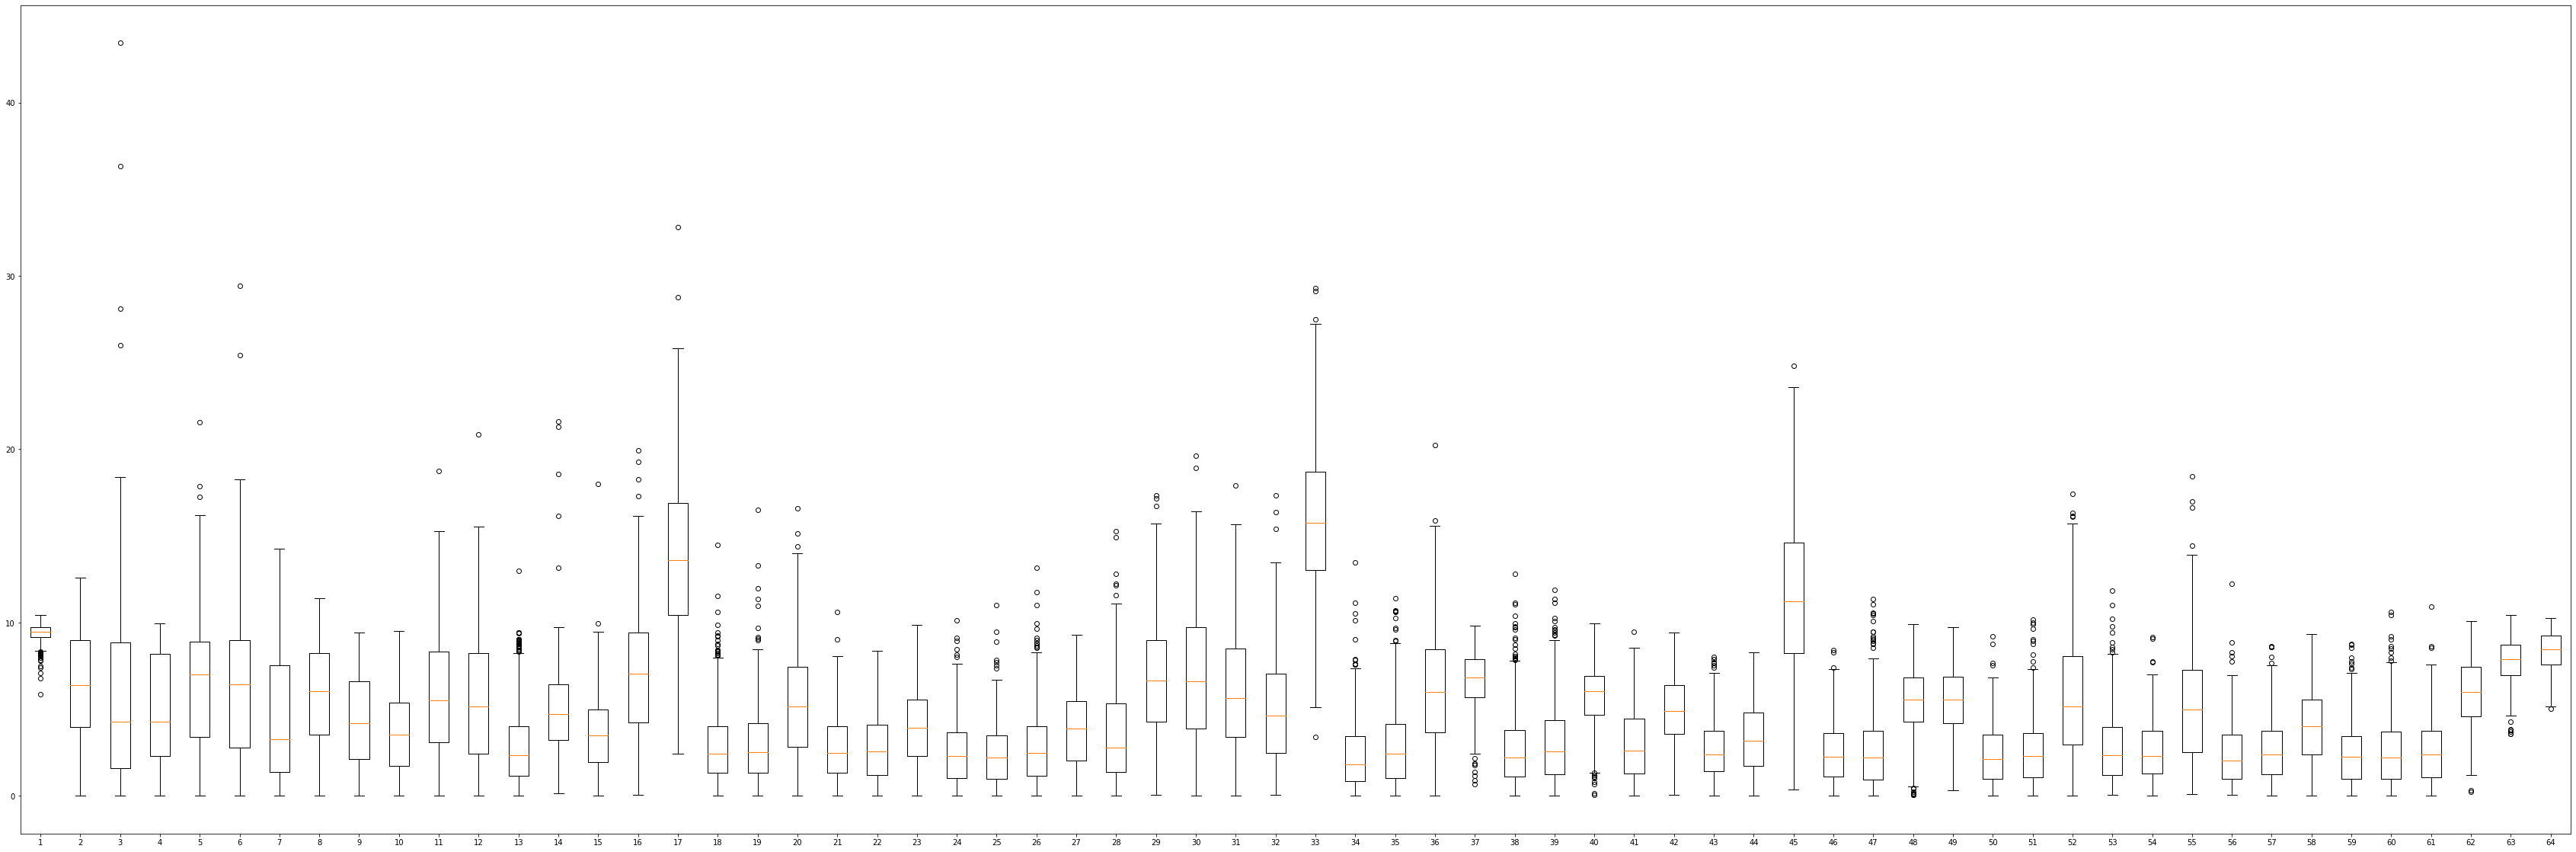

In [81]:
positions_for_bp = []
get_positions_for_boxplots(positions_for_bp, chunks_sums, chunks_avgs, to_plot=True)

In [82]:
positions_for_bp_medians = []
positions_for_bp_avg = []

get_positions_medians_and_avgs(positions_for_bp, positions_for_bp_medians, positions_for_bp_avg)

In [83]:
max_10_median_diffs_pos = get_max_10_median_diffs_positions(positions_for_bp_medians)


In [84]:
max_10_median_diffs_pos

[27, 36, 15, 43, 44, 31, 16, 32, 62]

In [85]:
clusters = []
get_positions_clusters(positions_for_bp_medians, max_10_median_diffs_pos, clusters)

POSITIONS CLUSTERS:
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [16], [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], [28, 29, 30, 31], [32], [33, 34, 35, 36], [37, 38, 39, 40, 41, 42, 43], [44], [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], [63]]


In [86]:
positions = get_positions(clusters)

In [87]:
reads_for_observing = []
reads_for_observing_with_name = []
present_reads_with_positions(reads_for_observing, reads_for_observing_with_name, all_regions_with_name)

In [88]:
reads_for_observing_with_name

[([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'df5f7e8a-9b14-45a3-90f9-9a1481f74669'),
 ([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], '08dfbf92-0db1-4a8d-84e1-f13f661ecce4'),
 ([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], '0b5f10c0-515f-415b-be88-7951e2e882a3'),
 ([1, 0, 0, 0, 0, 1, 0, 0, 0, 0], '7a8f15a4-47bc-43c2-9900-4457d0b109e2'),
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], '8a7bd079-1267-45a8-b732-7f32918b4de9'),
 ([0, 0, 0, 0, 1, 0, 0, 0, 1, 0], 'e3068f09-cfbf-4e32-bc3e-10c971216323'),
 ([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 'f401bd6c-e502-4805-af95-ecc7dabfc704'),
 ([0, 0, 0, 1, 1, 0, 0, 0, 0, 0], 'd0539822-3b5f-411b-921e-e5c295059c11'),
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'deb87367-61bf-4523-97a1-32cd4343168b'),
 ([0, 1, 1, 0, 0, 0, 0, 0, 0, 0], '085e4e36-2e2e-4939-a17c-9f7ed7b55685'),
 ([0, 0, 0, 0, 1, 0, 0, 0, 1, 0], '14851307-c989-4735-87bc-de2302fc84b0'),
 ([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], '89022729-30c1-4674-b84c-12dfd88909bc'),
 ([0, 0, 0, 1, 1, 0, 0, 0, 0, 0], 'ed57c650-f3e0-4e9a-9438-6d0e81a67b16'),
 ([0, 0, 0, 1, 0, 0, 0, 0

## SAVING POSITIONS REAL DATA

In [90]:
save_positions_to_file(positions, "TPP_significant_positions.txt")
save_reads_with_positions("TPP_reads_with_significant_positions.txt", reads_for_observing_with_name)

## SAVING POSITIONS SIMULATED DATA 

In [71]:
save_positions_to_file(positions, "TPP_simulated_significant_positions.txt")
save_reads_with_positions("TPP_simulated_reads_with_significant_positions.txt", reads_for_observing_with_name)